<a href="https://colab.research.google.com/github/dernameistegal/airbnb_price/blob/main/gradient_boosting_old.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd

In [3]:
!git clone https://github.com/dernameistegal/airbnb_price.git

Cloning into 'airbnb_price'...
remote: Enumerating objects: 1250, done.
remote: Counting objects: 100% (1250/1250), done.
remote: Compressing objects: 100% (1182/1182), done.
remote: Total 1250 (delta 756), reused 317 (delta 58), pack-reused 0
Receiving objects: 100% (1250/1250), 10.50 MiB | 1.98 MiB/s, done.
Resolving deltas: 100% (756/756), done.



# Gradient Boosting regression

This example demonstrates Gradient Boosting to produce a predictive
model from an ensemble of weak predictive models. Gradient boosting can be used
for regression and classification problems. Here, we will train a model to
tackle a diabetes regression task. We will obtain the results from
:class:`~sklearn.ensemble.GradientBoostingRegressor` with least squares loss
and 500 regression trees of depth 4.

Note: For larger datasets (n_samples >= 10000), please refer to
:class:`~sklearn.ensemble.HistGradientBoostingRegressor`.


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
%cd airbnb_price
import sys
sys.path.append("/content/airbnb_price/custom_functions")
import general_utils as ut

/content/airbnb_price


In [ ]:
listings =pd.read_pickle("/content/drive/MyDrive/Colab/airbnb/data/data1/listings_workfile.pickle")

In [6]:
# Author: Peter Prettenhofer <peter.prettenhofer@gmail.com>
#         Maria Telenczuk <https://github.com/maikia>
#         Katrina Ni <https://github.com/nilichen>
#
# License: BSD 3 clause

import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets, ensemble
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from datetime import datetime

## Load the data

First we need to load the data.



In [ ]:
columns1 = set(listings.columns)
listings = listings.select_dtypes([np.number])
columns2 = set(listings.columns)
columns1 - columns2

{'description_en', 'host_about_en', 'lang', 'name_en', 'reviews_en'}

In [ ]:
train_ids, val_ids, test_ids = ut.train_val_test_split(listings.index)  
traindf = listings.loc[train_ids]
valdf = listings.loc[val_ids]

In [ ]:
y = listings["log_price"]
X = listings[listings.columns.difference(["price", "log_price"])] 


y_train, y_test = traindf["log_price"], valdf["log_price"]
X_train, X_test = traindf[traindf.columns.difference(["price", "log_price"])], valdf[valdf.columns.difference(["price", "log_price"])]


## Data preprocessing

Next, we will split our dataset to use 70% for training and 15% for validation. We will also set the regression model parameters. You can play
with these parameters to see how the results change.

`n_estimators` : the number of boosting stages that will be performed.
Later, we will plot deviance against boosting iterations.

`max_depth` : limits the number of nodes in the tree.
The best value depends on the interaction of the input variables.

`min_samples_split` : the minimum number of samples required to split an
internal node.

`learning_rate` : how much the contribution of each tree will shrink.

`loss` : loss function to optimize. The least squares function is  used in
this case however, there are many other options (see
:class:`~sklearn.ensemble.GradientBoostingRegressor` ).



In [ ]:
params = {
    "n_estimators": 5000,
    "max_depth": 10,
    "min_samples_split": 5,
    "learning_rate": 0.01,
    "loss": "squared_error",
}

In [ ]:
# Baseline performance
mean_prediction = np.mean(y_train)

mse = mean_squared_error(y_test, np.ones(len(y_test)) * mean_prediction)
print("The root mean squared error (MSE) on test set: {:.4f}".format(np.sqrt(mse)))

The root mean squared error (MSE) on test set: 0.6490


## Fit regression model

Now we will initiate the gradient boosting regressors and fit it with our
training data. Let's also look and the mean squared error on the test data.



In [ ]:
start = datetime.now()

reg = ensemble.GradientBoostingRegressor(**params, verbose=1)
reg.fit(X_train, y_train)

mse = mean_squared_error(y_test, reg.predict(X_test))

end = datetime.now()
print("time to obtain model: ", (end-start).total_seconds())
print("The root mean squared error (MSE) on test set: {:.4f}".format(np.sqrt(mse)))

      Iter       Train Loss   Remaining Time 
         1           0.4316           11.17m
         2           0.4257           11.29m
         3           0.4199           11.31m
         4           0.4142           11.34m
         5           0.4086           11.70m
         6           0.4032           11.69m
         7           0.3978           11.83m
         8           0.3925           11.73m
         9           0.3873           11.64m
        10           0.3822           11.63m
        20           0.3361           11.34m
        30           0.2978           11.19m
        40           0.2654           11.22m
        50           0.2381           11.14m
        60           0.2148           11.11m
        70           0.1947           11.06m
        80           0.1775           11.02m
        90           0.1622           11.00m
       100           0.1488           10.96m
       200           0.0757           10.72m
       300           0.0445           10.50m
       40

## Plot training deviance

Finally, we will visualize the results. To do that we will first compute the
test set deviance and then plot it against boosting iterations.



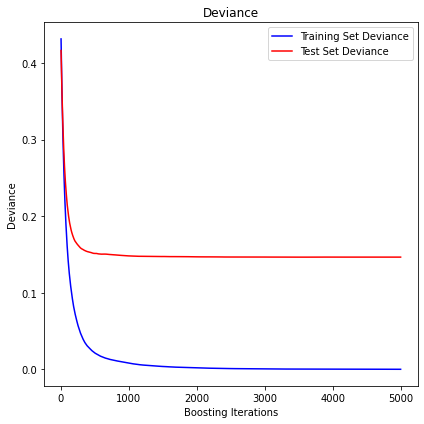

In [ ]:
test_score = np.zeros((params["n_estimators"],), dtype=np.float64)
for i, y_pred in enumerate(reg.staged_predict(X_test)):
    test_score[i] = reg.loss_(y_test, y_pred)

fig = plt.figure(figsize=(6, 6))
plt.subplot(1, 1, 1)
plt.title("Deviance")
plt.plot(
    np.arange(params["n_estimators"]) + 1,
    reg.train_score_,
    "b-",
    label="Training Set Deviance",
)
plt.plot(
    np.arange(params["n_estimators"]) + 1, test_score, "r-", label="Test Set Deviance"
)
plt.legend(loc="upper right")
plt.xlabel("Boosting Iterations")
plt.ylabel("Deviance")
fig.tight_layout()
plt.show()

## Plot feature importance

<div class="alert alert-danger"><h4>Warning</h4><p>Careful, impurity-based feature importances can be misleading for
   **high cardinality** features (many unique values). As an alternative,
   the permutation importances of ``reg`` can be computed on a
   held out test set. See `permutation_importance` for more details.</p></div>

For this example, the impurity-based and permutation methods identify the
same 2 strongly predictive features but not in the same order. The third most
predictive feature, "bp", is also the same for the 2 methods. The remaining
features are less predictive and the error bars of the permutation plot
show that they overlap with 0.



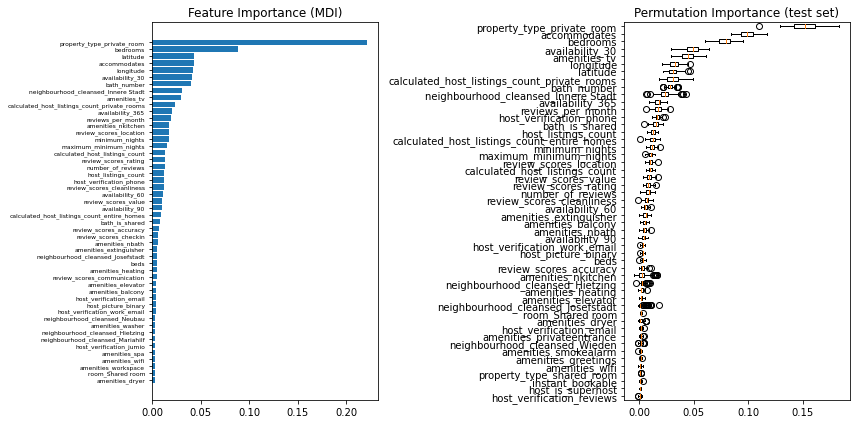

time to generate permutation importance:  4819.930598


In [ ]:
start = datetime.now()
n_features = 50

feature_importance = reg.feature_importances_
sorted_idx = np.argsort(feature_importance)[::-1]
sorted_idx = sorted_idx[:n_features][::-1]
pos = np.arange(sorted_idx.shape[0]) + 0.5
fig = plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align="center")
plt.yticks(pos, np.array(X.columns)[sorted_idx], fontsize=6)
plt.title("Feature Importance (MDI)")

result = permutation_importance(
    reg, X_test, y_test, n_repeats=100, random_state=42, n_jobs=2
)
sorted_idx2 = result.importances_mean.argsort()[::-1]
sorted_idx2 = sorted_idx2[:n_features][::-1]
plt.subplot(1, 2, 2)
plt.boxplot(
    result.importances[sorted_idx2].T,
    vert=False,
    labels=np.array(X.columns)[sorted_idx2],
)
plt.title("Permutation Importance (test set)")
fig.tight_layout()
plt.show()

end = datetime.now()
print("time to generate permutation importance: ", (end-start).total_seconds())

In [ ]:
# make dataframe from feature importances
df = pd.DataFrame(result.importances, index=X.columns)

In [32]:
# save dataframe 
path = "/content/drive/MyDrive/Colab/airbnb/data/feature_selection/permutation_importance.pickle"
df.to_pickle(path)

In [37]:
# load dataframe
df = pd.read_pickle("/content/drive/MyDrive/Colab/airbnb/data/feature_selection/permutation_importance.pickle")

In [38]:
# calculate importances_mean
importances_mean = np.array(np.mean(df, axis=1))

In [39]:
# significance test
significant = np.sum(np.array(df) >= 0, axis=1) >= 95
index_significant = np.where(significant)[0]

In [40]:
# get column names, importances and mean importances that are significant
importances_mean_significant = importances_mean[index_significant]
importances_significant = np.array(df)[index_significant]
columns_significant = df.index[index_significant]

In [42]:
# argsort to select only the 69 most important features of all significant features
sorted_idx = importances_mean_significant.argsort()[::-1]
sorted_idx = sorted_idx[:69]
sorted_idx = sorted_idx[::-1]

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 138 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/textpath.py:84: RuntimeWarning: Glyph 138 missing from current font.
  font.set_text(s, 0.0, flags=LOAD_NO_HINTING)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 138 missing from current font.
  font.set_text(s, 0, flags=flags)


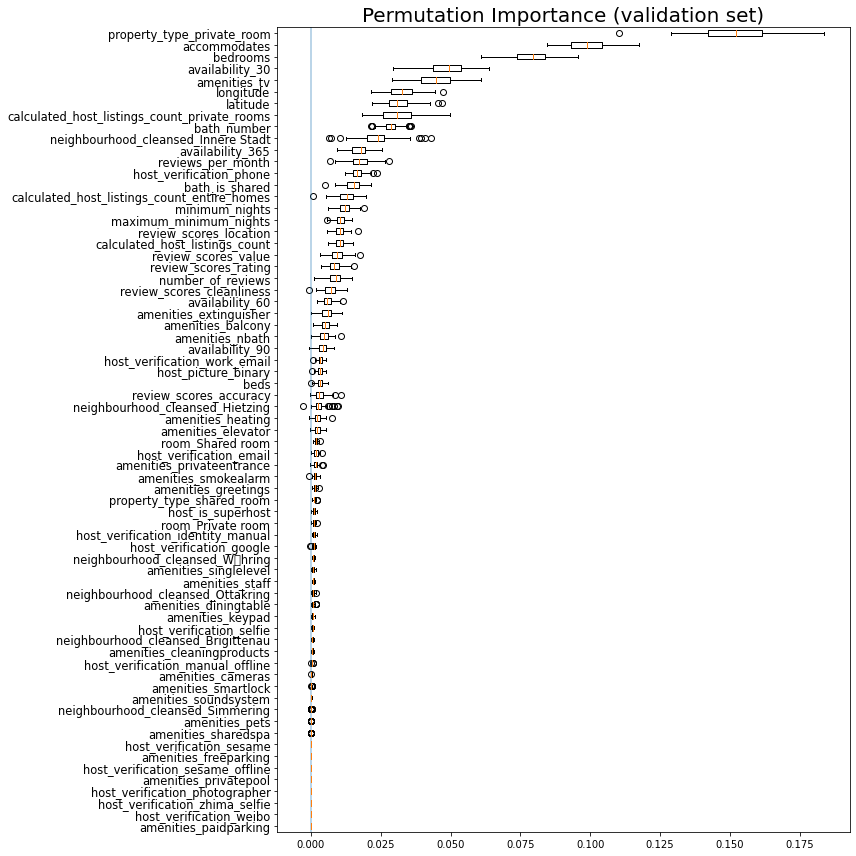

In [44]:
fig = plt.figure(figsize=(12, 12))
plt.yticks(fontsize=11.5)
plt.boxplot(
    importances_significant[sorted_idx].T,
    vert=False,
    labels=np.array(columns_significant)[sorted_idx],
)
plt.axvline(x=0, alpha=0.4)
plt.title("Permutation Importance (validation set)", fontsize=20)
fig.tight_layout()
plt.savefig(str("/content/file0.svg"), bbox_inches='tight', format="svg", transparent=True)
plt.show()

In [ ]:
np.save("/content/drive/MyDrive/Colab/airbnb/data/feature_selection/selected_features.npy", np.array(columns_significant)[sorted_idx])